In [1]:
import numpy as np
import pandas as pd
import torchvision
import matplotlib.pyplot as plt

from analysis import *

In [2]:
# load data and set variables
# TODO: plot human and NN on the same plot, if possible

human_anns = load_human_anns()
NN_anns = load_NN_anns() # this function takes time

Files already downloaded and verified
Files already downloaded and verified


In [84]:
class_names = [
    'plane',
    'car',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]
n_classes = 10
n_nets = 9
n_participants = len(human_anns)
participant_ids = [3, 4, 6, 9, 10, 11, 12, 13, 14, 15, 16]
convs = [1, 2, 3]
chs = [16, 32, 64]
net_names = ["SimpleNet_conv=%d_ch=%d" % (i, j) for i in convs for j in chs]
image_ids = list(human_anns[3].keys())
image_labels = [entry['gt'] for entry in human_anns[3].values()]
n_images = 60

In [85]:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True)
images = [np.array(img) for (img, y) in testset]

Files already downloaded and verified


In [86]:
data_human = np.zeros((n_classes, n_participants))

for p_id, ann in human_anns.items():
    for img, entry in ann.items():
        
        gt = entry['gt']
        label = entry['label']
        p = participant_ids.index(p_id)
        data_human[gt, p] += (gt == label)

# each participant saw 6 images from each class
data_human = data_human / (n_images / n_classes)

data_NN = np.zeros((n_classes, n_nets))

for name, ann in NN_anns.items():
    for img, entry in ann.items():
        
        gt = entry['gt']
        label = entry['label']
        n = net_names.index(name)
        data_NN[gt, n] += (gt == label)

# each participant saw 6 images from each class
data_NN = data_NN / (n_images / n_classes)

In [87]:
# compare performance by class for both human and NN
# class acc +/- 1 std.

ind = np.arange(n_classes)
means_human = np.mean(data_human, axis=1)
means_NN = np.mean(data_NN, axis=1)
std_human = np.std(data_human, axis=1)
std_NN = np.std(data_NN, axis=1)

plt.figure()
plt.bar(ind-0.2, means_human, 0.4, yerr=std_human, label='human')
plt.bar(ind+0.2, means_NN, 0.4, yerr=std_NN, label='NN')
plt.xticks(ind, class_names)
plt.title("Performance by Class ($\pm 1 \sigma$)")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1, 1.05))
plt.savefig("results/performance_by_class.svg", format='svg')

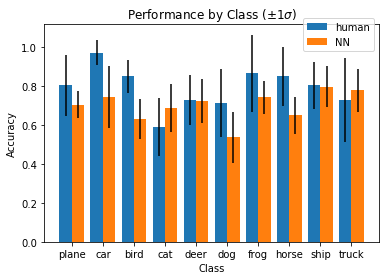

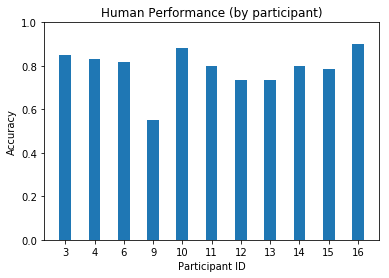

In [88]:
# compare human performance by participant

ind = np.arange(n_participants)
means = np.mean(data_human, axis=0)

plt.figure()
plt.bar(ind, means, 0.4)
plt.xticks(ind, ["%d" % p_id for p_id in participant_ids])
plt.title("Human Performance (by participant)")
plt.xlabel("Participant ID")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

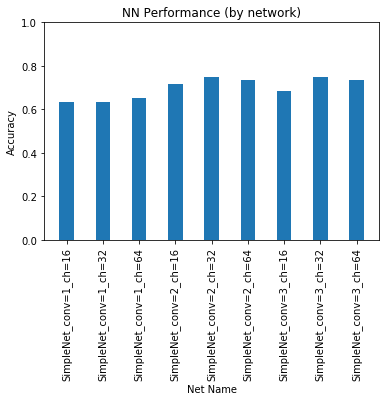

In [89]:
# NN performance by participant

ind = np.arange(n_nets)
means = np.mean(data_NN, axis=0)

plt.figure()
plt.bar(ind, means, 0.4)
plt.xticks(ind, ["%s" % name for name in net_names], rotation='vertical')
plt.title("NN Performance (by network)")
plt.xlabel("Net Name")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()

In [90]:
# human annotation distribution per image
distribution_human = np.zeros((n_images, n_classes))

for p_id, ann in human_anns.items():
    for img_id, entry in ann.items():
        
        i = image_ids.index(img_id)
        label = entry['label']
        distribution_human[i][label] += 1
        
# set row sums to 1
distribution_human = distribution_human / n_participants

In [91]:
# NN prediction distribution per image
distribution_NN = np.zeros((n_images, n_classes))

for p_id, ann in NN_anns.items():
    for img_id, entry in ann.items():
        
        i = image_ids.index(img_id)
        label = entry['label']
        distribution_NN[i][label] += 1

# set row sums to 1
distribution_NN = distribution_NN / n_nets

In [92]:
# Human vs. NN performance by image difficulty rank
image_accs_human = [dist[true] for dist, true in zip(distribution_human, image_labels)]
image_accs_human.sort(reverse=True)

image_accs_NN = [dist[true] for dist, true in zip(distribution_NN, image_labels)]
image_accs_NN.sort(reverse=True)

plt.figure()
plt.plot(1+np.arange(n_images), image_accs_human, label='human')
plt.plot(1+np.arange(n_images), image_accs_NN, label='NN')
plt.title("Difficulty Dropoff")
plt.xlabel("Image Rank")
plt.ylabel("Image Accuracy")
plt.legend()
plt.savefig("results/difficulty_dropoff.svg", format='svg')

In [93]:
# Human confusion matrix (all annotators)
confusion = confusion_matrix(image_labels, distribution_human, n_classes)

# https://stackoverflow.com/questions/3529666
plt.figure()
fig, (ax) = plt.subplots(1, 1, figsize=(10, 10))
cax = ax.matshow(confusion)
ax.set_title("Human Class Confusion (diagonal zeroed)")
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
ax.set_xticks(np.arange(n_classes))
ax.set_yticks(np.arange(n_classes))
ax.set_yticklabels(class_names)
ax.set_xticklabels(class_names)
fig.colorbar(cax, cmap='rgb')

plt.savefig("results/human_confusion.svg", format='svg')

In [94]:
# NN confusion matrix (all networks)
confusion = confusion_matrix(image_labels, distribution_NN, n_classes)

# https://stackoverflow.com/questions/3529666
plt.figure()
fig, (ax) = plt.subplots(1, 1, figsize=(10, 10))
cax = ax.matshow(confusion)
ax.set_title("NN Class Confusion (diagonal zeroed)")
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
ax.set_xticks(np.arange(n_classes))
ax.set_yticks(np.arange(n_classes))
ax.set_yticklabels(class_names)
ax.set_xticklabels(class_names)
fig.colorbar(cax, cmap='rgb')

plt.savefig("results/NN_confusion.svg", format='svg')

In [95]:
# human difficulty ranking vs NN difficulty ranking

image_human = np.zeros((n_images, n_participants))

for p_id, ann in human_anns.items():
    for img, entry in ann.items():
        
        img_id = image_ids.index(img)
        gt = entry['gt']
        label = entry['label']
        p = participant_ids.index(p_id)
        image_human[img_id, p] += (gt == label)

# get image indices by bin
img_percentile = {
    0.0: [9086, 6104, 839, 673, 267, 1650, 2445, 6149, 8195, 3982], 
    0.2: [7863, 6550, 6170, 3456, 6362, 7433, 772, 2663, 1742, 5772], 
    0.4: [7811, 1493, 1709, 6075, 805, 5549, 9166, 6504, 7088, 6557], 
    0.6: [1912, 8645, 2938, 5986, 6802, 7539, 95, 5246, 2, 7578], 
    0.8: [2704, 6300, 972, 4864, 7410, 925, 6443, 7669, 9291, 2186], 
    1.0: [1072, 7638, 5324, 2405, 6753, 4139, 3615, 1100, 7217, 6522]
}
n_bins = len(img_percentile)

img_ids_percentile = {
    p: [image_ids.index(img_id) for img_id in id_list]
        for (p, id_list) in img_percentile.items()
}

# X = NN difficulty bins
# Y = Human acc. over images in the bin, error bar over humans
bin_names = ["%.1f" % p for p in img_percentile]
errs_per_bin = []
accs_per_bin = []

for p, img_ids in img_ids_percentile.items():
    
    acc_per_person = np.mean(image_human[img_ids, :], axis=0)
    
    accs_per_bin.append(np.mean(acc_per_person))
    errs_per_bin.append(np.std(acc_per_person))

ind = np.arange(n_bins)
plt.figure()
plt.bar(ind, accs_per_bin, 0.4, yerr=errs_per_bin)
plt.xticks(ind, bin_names)
plt.title("Human and NN Difficulty Trend ($\pm 1 \sigma$)")
plt.xlabel("NN Loss Percentile")
plt.ylabel("Human Accuracy")
plt.savefig("results/difficulty_trend.svg", format='svg')